Import Libraries

In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

Dataset Configuration

In [2]:
source_dir = "Malware as Images"
image_size = (224, 224)
batch_size = 32
epochs = 20

# Top-level class labels: 'benign', 'malicious'
classes = sorted(
    d for d in os.listdir(source_dir)
    if os.path.isdir(os.path.join(source_dir, d))
)

# Gather all image file paths and labels from nested subfolders
file_paths, labels = [], []
for label, cls in enumerate(classes):
    cls_root = os.path.join(source_dir, cls)
    for subdir, _, files in os.walk(cls_root):
        for fname in files:
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                fpath = os.path.join(subdir, fname)
                file_paths.append(fpath)
                labels.append(label)

Split Dataset

In [3]:
X_train, X_temp, y_train, y_temp = train_test_split(
    file_paths, labels,
    test_size=0.30,
    stratify=labels,
    random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=42
)

TF-Data Pipeline

In [4]:
def process_path(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, image_size)
    img = resnet_preprocess_input(img)
    label = tf.one_hot(label, depth=len(classes))
    return img, label

def make_dataset(X, y, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(X))
    return (
        ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
          .batch(batch_size)
          .prefetch(tf.data.AUTOTUNE)
    )

train_ds = make_dataset(X_train, y_train, shuffle=True).repeat()
val_ds   = make_dataset(X_val,   y_val,   shuffle=False)
test_ds  = make_dataset(X_test,  y_test,  shuffle=False)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Spatial Aggregation Vector Encoding (SAVE) Layer

In [5]:
class SpatialAggregationLayer(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, input_shape):
        self.alpha_top    = self.add_weight('alpha_top',    (1,), initializer='ones')
        self.alpha_bottom = self.add_weight('alpha_bottom', (1,), initializer='ones')
        self.alpha_left   = self.add_weight('alpha_left',   (1,), initializer='ones')
        self.alpha_right  = self.add_weight('alpha_right',  (1,), initializer='ones')
        super().build(input_shape)

    def call(self, inputs):
        t = tf.roll(inputs, -1, axis=1)
        b = tf.roll(inputs,  1, axis=1)
        l = tf.roll(inputs, -1, axis=2)
        r = tf.roll(inputs,  1, axis=2)
        return inputs + self.alpha_top * t + self.alpha_bottom * b + self.alpha_left * l + self.alpha_right * r


Build ResNet50 Model with SAVE

In [6]:
def build_resnet50_model(num_classes, image_size=image_size):
    backbone = ResNet50(
        input_shape=(*image_size, 3),
        include_top=False,
        weights='imagenet'
    )
    x = backbone.output
    x = SpatialAggregationLayer()(x)
    x = Flatten()(x)
    x = Dense(1000, activation="relu")(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs=backbone.input, outputs=outputs)
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.FalsePositives(name='false_positives'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
        ]
    )
    return model

model = build_resnet50_model(num_classes=len(classes))
model.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                

Model Training

In [7]:
os.makedirs('checkpoints', exist_ok=True)
os.makedirs('models', exist_ok=True)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath='checkpoints/resnet50_malware_best.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

history = model.fit(
    train_ds,
    epochs=epochs,
    steps_per_epoch=len(X_train) // batch_size,
    validation_data=val_ds,
    callbacks=[checkpoint_cb]
)

model.save('models/resnet50_malware_final.h5')

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
24/24 [==============================] - ETA: 0s - loss: 79.1646 - accuracy: 0.7122 - auc: 0.7254 - false_positives: 221.0000 - precision: 0.7122 - recall: 0.7122 WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001C5F0F6A798> and will run it as-is.
Please report this to the TensorFlow team. When fil

Plot Training History

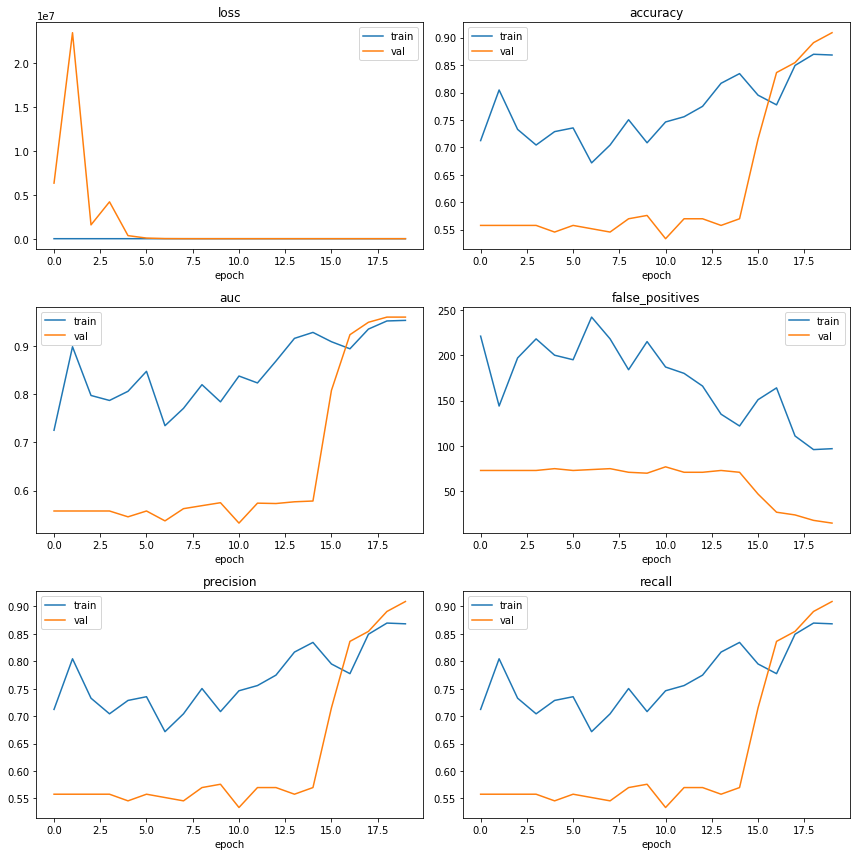

In [8]:
def plot_history(hist):
    metrics = ['loss', 'accuracy', 'auc', 'false_positives', 'precision', 'recall']
    fig, axes = plt.subplots(3, 2, figsize=(12, 12))
    for idx, m in enumerate(metrics):
        ax = axes[idx // 2, idx % 2]
        ax.plot(hist.history[m], label='train')
        ax.plot(hist.history[f'val_{m}'], label='val')
        ax.set_title(m)
        ax.set_xlabel('epoch')
        ax.legend()
    plt.tight_layout()
    plt.show()

plot_history(history)

Model Validation

In [9]:
val_metrics = model.evaluate(val_ds, verbose=1)
print("\nValidation set metrics:")
for name, value in zip(model.metrics_names, val_metrics):
    print(f" - {name}: {value:.4f}")

6/6 [==============================] - 12s 2s/step - loss: 0.2626 - accuracy: 0.9091 - auc: 0.9607 - false_positives: 15.0000 - precision: 0.9091 - recall: 0.9091

Validation set metrics:
 - loss: 0.2626
 - accuracy: 0.9091
 - auc: 0.9607
 - false_positives: 15.0000
 - precision: 0.9091
 - recall: 0.9091


Model Testing

In [10]:
start = time.time()
preds = model.predict(test_ds)
print(f"\nInference time on test set: {time.time() - start:.2f}s")

y_true = np.argmax(np.vstack([y for _, y in test_ds.unbatch()]), axis=1)
y_pred = np.argmax(preds, axis=1)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=classes))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
6/6 [==============================] - 28s 2s/step

Inference time on test set: 28.83s

Classification Report:

              precision    recall  f1-score   support

      benign       0.97      0.80      0.87        74
   malicious       0.86      0.98      0.91        91

    accuracy                           0.90       165
   macro avg       0.91      0.89      0.89     

Confusion Matrix Plot

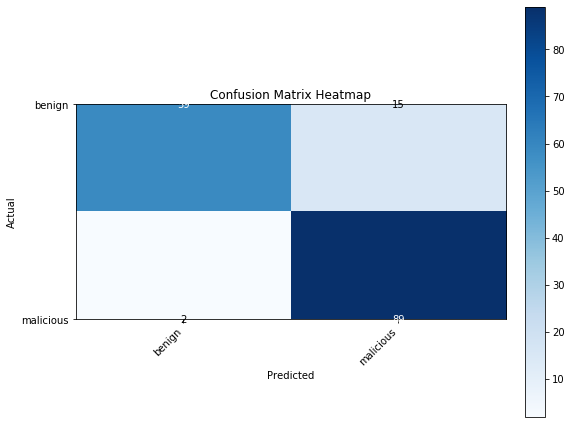

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix Heatmap')
plt.imshow(cm, interpolation='nearest', aspect='auto')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.colorbar(fraction=0.046, pad=0.04)

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45, ha='right')
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, f"{cm[i, j]:d}", ha='center', va='center', color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.show()